# Intro

The goal of this notebook is to present implementations of three important loss functions for this problem and compare their effects on a simplified implementation of U-Net. The loss functions in question are binary cross entropy (referred to as "nll" in the notebook because my initial version used the related NLLLoss instead of BCEWithLogitLoss), the soft Dice loss (introduced here: http://campar.in.tum.de/pub/milletari2016Vnet/milletari2016Vnet.pdf and considered to be useful for segmentation problems), and the focal loss, the investigation of which is the main focus of this notebook.

The focal loss is described in "Focal Loss for Dense Object Detection" (https://arxiv.org/pdf/1708.02002.pdf) and is simply a modified version of binary cross entropy in which the loss for confidently correctly classified labels is scaled down, so that the network focuses more on incorrect and low confidence labels than on increasing its confidence in the already correct labels.

In the image below, you can see the ordinary binary cross entropy loss function as the top line and different variants of focal loss (focal loss is parameterized by $\gamma$, $\gamma = 0$ is the same as binary cross entropy). We can clearly see that focal loss places much less importance on examples for which the confidence is high than ordinary BCE.

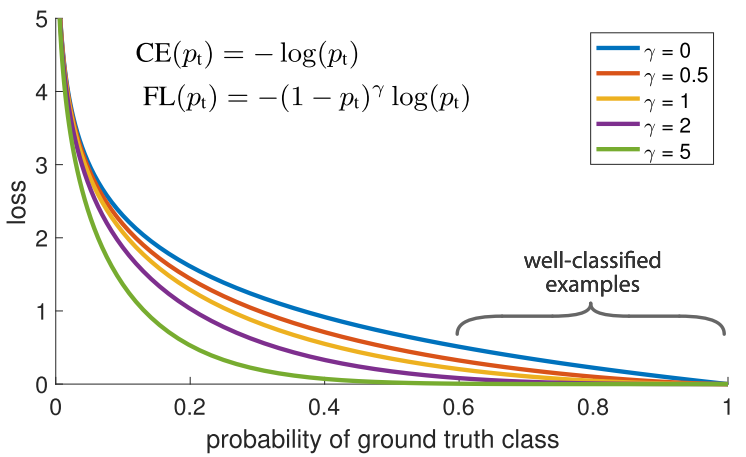

In addition, this notebook also investigates a claim made in "Focal Loss for Dense Object Detection":

> Binary classification models are by default initialized to
have equal probability of outputting either y = −1 or 1. Under such an initialization, in the presence of class imbal-
ance, the loss due to the frequent class can dominate total loss and cause instability in early training. To counter this, we introduce the concept of a ‘prior’ for the value of p estimated by the model for the rare class (foreground) at the start of training. We denote the prior by π and set it so that the model’s estimated p for examples of the rare class is low, e.g. 0.01. We note that this is a change in model initialization (see §4.1) and not of the loss function. We found this to improve training stability for both the cross entropy and focal loss in the case of heavy class imbalance.

Basically the paper claims that in cases where the probability of each class isn't close to 50/50, it is useful to initialize the model so that on average it will output the actual probability of each class, so that the loss isn't very large at the beginning of training.

Because the setting of the competition is different from that in the paper (eg we are looking for masks instead of bounding boxes, and the class imbalance is actually not that bad: 12% of pixels in the training set contain a cell), we definitely expect different results. The point of this notebook is to explore those differences. It would be interesting to implement something closer to what the paper describes to fully investigate the usefulness of focal loss for the data science bowl 2018.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Note: not all the imports below are necessary, they are just copied from my main notebook.

In [2]:
import glob
import cv2
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook as tqdm
import os.path
import csv
import joblib
import PIL
import pandas as pd
import math
from sklearn.model_selection import train_test_split
from functools import reduce
from Augmentor.Pipeline import Pipeline
from Augmentor.ImageUtilities import AugmentorImage


Some useful utilities:
- cache is a decorator that will store the output of expensive functions on disk.
- w is a wrapper function that sends (or does not send) PyTorch objects to gpu depending on whether a USE_CUDA variable is set.

In [3]:
!mkdir -p _cache_focal
cache = joblib.Memory(cachedir='ce_dice_cache/_cache_focal', verbose=0)

USE_CUDA = True

def w(v):
    if USE_CUDA:
        return v.cuda()
    return v


# Utils

## Evaluation

These are the various evaluation functions I have been using, they allow us to compute iou and also to compress and generate the csv file.

Note: these are just copied from my main notebook for this competition. They aren't necessarily all used in this notebook.


In [4]:
def uncombine(mask):
    max_val = np.max(mask) + 1
    results = []
    for i in range(1, max_val):
        results.append(mask == i)
    return results

def iou(mask1, mask2):
    return np.sum(mask1 & mask2) / np.sum(mask1 | mask2)

def evaluate_split(labels, y_pred):
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))
    #print("Number of true objects:", true_objects)
    #print("Number of predicted objects:", pred_objects)

    # Compute intersection between all objects
    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    #print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if tp + fp + fn == 0:
            p = 1.0
        else:
            p = tp / (tp + fp + fn)
        #print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    #print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def evaluate_combined(combined_mask_true, combined_mask_pred):    
    return evaluate_split(combined_mask_true, combined_mask_pred)

def evaluate_naive_tuple(tup):
    return evaluate_naive(*tup)

def classify_naive(image, factor, kernel_sz):
    if np.median(image) < 127:
        thresholded = (image > np.mean(image) + np.std(image) * factor).astype(np.uint8) * 255
    else:
        thresholded = (image < np.mean(image) - np.std(image) * factor).astype(np.uint8) * 255

    kernel = np.ones((kernel_sz, kernel_sz))
    thresholded = cv2.morphologyEx(thresholded, cv2.MORPH_OPEN, kernel)
    thresholded = cv2.morphologyEx(thresholded, cv2.MORPH_CLOSE, kernel)
        
    _, connected = cv2.connectedComponents(thresholded)
    
    return connected

def evaluate_naive(folder, factor, kernel_sz):
    image = glob.glob(folder + '/images/*')[0]
    image = imread(image)
    masks = glob.glob(folder + '/masks/*')
    total_mask = None
    for i, m in enumerate(masks):
        m = (imread(m) // 255).astype(np.int32)
        if total_mask is None:
            total_mask = m
        else:
            total_mask += m * (i+1)
            
    connected = classify_naive(image, factor, kernel_sz)
    
    return evaluate_combined(total_mask, connected)

def rle(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def rle_combined(combined):
    all_rle = []
    if np.max(combined) == 0:
        combined[0, 0] = 1
    max_val = np.max(combined) + 1
    for i in range(1, max_val):
        all_rle.append(rle(combined == i))
    return all_rle

# TODO: test rle by encoding and decoding and figuring out if it matches

def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(lab_img, cut_off = 0.5):
    if lab_img.max()<1:
        lab_img[0,0] = 1 # ensure at least one prediction per image
    for i in range(1, lab_img.max()+1):
        yield rle_encoding(lab_img==i)
        
def open_res_csv(key=''):
    cur = 0
    while True:
        path = '_%s_submit_%03d.csv' % (key, cur)
        if not os.path.exists(path):
            return open(path, 'w')
        cur += 1
        
def find_clusters(img):
    return cv2.connectedComponents((img > 0.5).astype(np.uint8))[1]


## Loading

Just a few loading functions.

Note that crucially I am **eroding** the different masks, so that no two masks can touch each other. 

Here is an example of a full mask image if erosion is disabled:

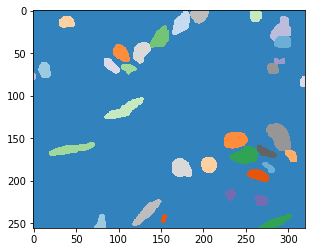

As you can see for example on the upper-right corner, some masks completely touch each other. Because our approach for finding individual cells once the pixels are labeled will be based on finding connected components, we would merge these two nuclei into a single one in our submission and thus hurt our IoU.


Perhaps the simplest way to fix this is to teach our network to label pixels which are *inside the nucleus* by at least 1 pixel. This way two distinct nuclei can't touch each other, and we can expand the masks by one pixels once the nuclei are found. For this we use the erosion operation when we load our training labels, and the dilation operation when we generate our submission.

Here is the image above after erosion of the masks:

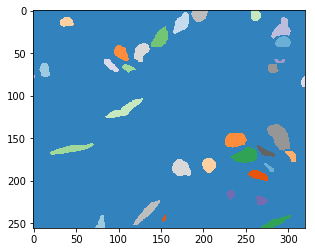

As you can see, no two masks touch anymore!

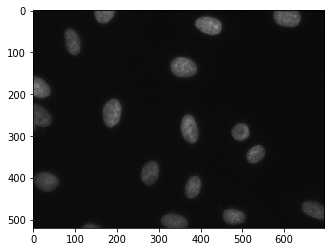

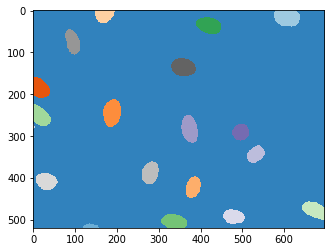

In [5]:
def load_image_labels(folder, border_sz=1):
    image = glob.glob(folder + '/images/*')[0]
    image = cv2.imread(image)[:, :, ::-1]
    masks = glob.glob(folder + '/masks/*')
    all_masks = []
    for i, mask in enumerate(masks):
        mask_img = np.sum(cv2.imread(mask), axis=-1)
        mask_img = cv2.erode(mask_img.astype(np.uint8),np.ones((3, 3), np.uint8),iterations = 1)
        all_masks.append((mask_img.astype(np.int16) * (i + 1)))
    if len(masks) == 0:
        return image
    return image, np.sum(all_masks, axis=0, dtype=np.int16)

def convert_masks(masks, border_sz=2):
    return np.sum(
        [extract_border(mask, border_sz) for mask in masks],
        axis=0
    )

folder = glob.glob('../data/stage1_train/*')[9]
img, masks = load_image_labels(folder)
plt.imshow(img)
plt.show()
plt.imshow(masks, cmap='tab20c')
plt.show()

In [6]:
@cache.cache
def load_train_data():
    x = []
    y = []
    for path in glob.glob('../data/stage1_train/*/'):
        image, mask = load_image_labels(path)
        x.append(PIL.Image.fromarray(image))
        y.append(PIL.Image.fromarray(mask))
    return x, y

#load_train_data.clear()

FULL_TRAIN_X, FULL_TRAIN_Y = load_train_data()

In [7]:
TRAIN_X, VAL_X, TRAIN_Y, VAL_Y = train_test_split(FULL_TRAIN_X, FULL_TRAIN_Y, test_size=0.1, random_state=0)

# Implementation

## Model

This is a U-Net (https://arxiv.org/abs/1505.04597) inspired model. Note that the UNetClassify class implements the bias initialization described in the paper!

In [8]:
DROPOUT = 0.5

class UNetBlock(nn.Module):
    def __init__(self, filters_in, filters_out):
        super().__init__()
        self.filters_in = filters_in
        self.filters_out = filters_out
        self.conv1 = nn.Conv2d(filters_in, filters_out, (3, 3), padding=1)
        self.norm1 = nn.BatchNorm2d(filters_out)
        self.conv2 = nn.Conv2d(filters_out, filters_out, (3, 3), padding=1)
        self.norm2 = nn.BatchNorm2d(filters_out)
        
        self.activation = nn.ReLU()
        
    def forward(self, x):            
        conved1 = self.conv1(x)
        conved1 = self.activation(conved1)
        conved1 = self.norm1(conved1)
        conved2 = self.conv2(conved1)
        conved2 = self.activation(conved2)
        conved2 = self.norm2(conved2)
        return conved2
        
class UNetDownBlock(UNetBlock):
    def __init__(self, filters_in, filters_out, pool=True):
        super().__init__(filters_in, filters_out)
        if pool:
            self.pool = nn.MaxPool2d(2)
        else:
            self.pool = lambda x: x
        
    def forward(self, x):
        return self.pool(super().forward(x))
    
class UNetUpBlock(UNetBlock):
    def __init__(self, filters_in, filters_out):
        super().__init__(filters_in, filters_out)
        self.upconv = nn.Conv2d(filters_in, filters_in // 2, (3, 3), padding=1)
        self.upnorm = nn.BatchNorm2d(filters_in // 2)

    def forward(self, x, cross_x):
        x = F.upsample(x, size=cross_x.size()[-2:], mode='bilinear')
        x = self.upnorm(self.activation(self.upconv(x)))
        x = torch.cat((x, cross_x), 1)
        return super().forward(x)

class UNet(nn.Module):
    def __init__(self, layers, init_filters):
        super().__init__()
        self.down_layers = nn.ModuleList()
        self.up_layers = nn.ModuleList()
        self.init_filters = init_filters
        
        filter_size = init_filters
        for _ in range(layers - 1):
            self.down_layers.append(
                UNetDownBlock(filter_size, filter_size*2)
            )
            filter_size *= 2
        self.down_layers.append(UNetDownBlock(filter_size, filter_size * 2, pool=False))
        for i in range(layers):
            self.up_layers.append(
                UNetUpBlock(filter_size * 2, filter_size)
            )
            filter_size //= 2
        
        self.data_norm = nn.BatchNorm2d(1)
        self.init_layer = nn.Conv2d(1, init_filters, (7, 7), padding=3)
        self.activation = nn.ReLU()
        self.init_norm = nn.BatchNorm2d(init_filters)
        self.dropout = nn.Dropout(DROPOUT)
                
    def forward(self, x):
        x = self.data_norm(x)
        x = self.init_norm(self.activation(self.init_layer(x)))
        
        saved_x = [x]
        for layer in self.down_layers:
            saved_x.append(x)
            x = self.dropout(layer(x))
        is_first = True
        for layer, saved_x in zip(self.up_layers, reversed(saved_x)):
            if not is_first:
                is_first = False
                x = self.dropout(x)
            x = layer(x, saved_x)
        return x
                                  
class UNetClassify(UNet):
    def __init__(self, *args, **kwargs):
        init_val = kwargs.pop('init_val', 0.5)
        super().__init__(*args, **kwargs)
        self.output_layer = nn.Conv2d(self.init_filters, 1, (3, 3), padding=1)
        
        for name, param in self.named_parameters():
            typ = name.split('.')[-1]
            if typ == 'bias':
                if 'output_layer' in name:
                    # Init so that the average will end up being init_val
                    param.data.fill_(-math.log((1-init_val)/init_val))
                else:
                    param.data.zero_()
        
    def forward(self, x):
        x = super().forward(x)
        # Note that we don't perform the sigmoid here.
        return self.output_layer(x)

## Loss functions

Binary cross entropy is unsurprisingly part of pytorch, but we need to implement soft dice and focal loss. For numerical stability purposes, focal loss tries to work in log space as much as possible.

In [9]:
# From: https://github.com/pytorch/pytorch/issues/1249
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return 1 - ((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth))

class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        # Inspired by the implementation of binary_cross_entropy_with_logits
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})".format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + ((-max_val).exp() + (-input - max_val).exp()).log()

        # This formula gives us the log sigmoid of 1-p if y is 0 and of p if y is 1
        invprobs = F.logsigmoid(-input * (target * 2 - 1))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.mean()

def get_loss(loss):
    if loss[0] == 'dice':
        print('dice')
        return dice_loss
    elif loss[0] == 'focal':
        print('focal')
        return w(FocalLoss(loss[1]))
    else:
        print('bce')
        return w(nn.BCEWithLogitsLoss())


**Bonus**: an implementation of multi-label focal loss with support for class weights as well! It functions just like NLLLoss and takes its input as a log softmax and its target as a LongTensor of the classes.

Sadly this version is *not* numerically stable, unlike the binary version above. In particular I have found that it worked well with $\gamma = 2$ but generated lots of NaNs with $\gamma = 0.5$.

In [10]:
def make_one_hot(labels, C=2):
    one_hot = w(torch.FloatTensor(labels.size(0), C, labels.size(2), labels.size(3)).zero_())
    target = one_hot.scatter_(1, labels.data, 1)
    
    target = w(Variable(target))
        
    return target

class FocalLossMultiLabel(nn.Module):
    def __init__(self, gamma, weight):
        super().__init__()
        self.gamma = gamma
        self.nll = nn.NLLLoss(weight=weight, reduce=False)
        
    def forward(self, input, target):
        loss = self.nll(input, target)
        
        one_hot = make_one_hot(target.unsqueeze(dim=1), input.size()[1])
        inv_probs = 1 - input.exp()
        focal_weights = (inv_probs * one_hot).sum(dim=1) ** self.gamma
        loss = loss * focal_weights
        
        return loss.mean()

## Datasets

I use the Augmentor library to convert images to grayscale and make sure they are all cropped to a fixed size. RepeatablePipeline is my implementation of a Pipeline in Augmentor that has the ability to repeat itself so that we can apply the same transformation to the original image and the mask.

In [11]:
class RepeatablePipeline(Pipeline):
    def sample_with_image_repeatable(self, image, state=None, save_to_disk=False):
        a = AugmentorImage(image_path=None, output_directory=None)
        a.image_PIL = image
        
        pystate = random.getstate()
        npstate = np.random.get_state()
        if state is not None:
            random.setstate(state[0])
            np.random.set_state(state[1])
        
        res = self._execute(a, save_to_disk)
        
        if state is None:
            # We weren't given a state, don't reset the state at all
            # and simply return the current state as the way to reproduce
            # this.
            return res, (pystate, npstate)
        else:
            # If we were given a state, put things back to normal
            random.setstate(pystate)
            np.random.set_state(npstate)
            return res, state
        
def get_pipeline(train=True, mask=False):
    pipeline = RepeatablePipeline()
    if train:
        pipeline.crop_by_size(1.0, SIZE, SIZE, centre=not train)
    if not mask:
        pipeline.greyscale(1.0)
    return pipeline

SIZE = 128

class CellDataset(torch.utils.data.Dataset):
    def __init__(self, images, mask_arrays, transform_pipeline, mask_pipeline):
        super().__init__()
        self.images = images
        self.mask_arrays = mask_arrays
        self.trans_pipeline = transform_pipeline
        self.mask_pipeline = mask_pipeline
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        ret_img, state = self.trans_pipeline.sample_with_image_repeatable(self.images[idx])
        ret_img = np.expand_dims(np.array(ret_img), -1)
        if np.min(ret_img) < 0.0:
            ret_img -= np.min(ret_img)
        if np.max(ret_img) > 255.0:
            ret_img = ret_img / np.max(ret_img) * 255.0
        masks = np.array(self.mask_pipeline.sample_with_image_repeatable(self.mask_arrays[idx], state)[0])
        return (ret_img / 255.0).astype(np.float32), np.expand_dims(masks.astype(np.float32), -1)

# Experiment

## Fitting

We implement a simple fit function that is parameterized on the loss and the init value.

In [12]:
BATCH_SIZE = 5

@cache.cache(ignore=['verbose'])
def fit(epochs, verbose=False, layers=4, lr=0.001, init_filters=32, loss='nll', init_val=0.5):
    net = w(UNetClassify(layers=layers, init_filters=init_filters, init_val=init_val))

    criterion = get_loss(loss)
    optimizer = optim.Adam(net.parameters(), lr=lr)
    train = torch.utils.data.DataLoader(
        dataset=CellDataset(TRAIN_X, TRAIN_Y, get_pipeline(), get_pipeline(mask=True)),
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=6
    )
    val = torch.utils.data.DataLoader(
        dataset=CellDataset(VAL_X, VAL_Y, get_pipeline(train=False), get_pipeline(train=False, mask=True)),
        batch_size=1,
        shuffle=False,
        num_workers=2
    )

    print(dir(train))
    
    best_iou = -1.0
    best_net_dict = None
    best_epoch = -1
    best_loss = 1000.0
    
    for epoch in tqdm(range(epochs), f'Full Run'):
        net.train()
        train_losses = []
        for batch, labels in train:
            batch = w(autograd.Variable(batch.permute(0, 3, 1, 2)))
            labels = w(autograd.Variable((labels >= 1).float().permute(0, 3, 1, 2)))
            
            optimizer.zero_grad()
            output = net(batch)
            loss = criterion(output, labels)                
            loss.backward()
            train_losses.append(loss.data.cpu().numpy()[0])
            
            optimizer.step()
        print('train loss', np.mean(train_losses))
        
        net.eval()
        losses = []
        iou = []
        to_show = random.randint(0, len(val) - 1)
        for batch, labels_true in val:
            assert len(batch) == 1
            labels = w(autograd.Variable((labels_true >= 1).float().permute(0, 3, 1, 2)))
            batch = w(autograd.Variable(batch.permute(0, 3, 1, 2)))
            output = net(batch)
            loss = criterion(output, labels)
            losses += [loss.data.cpu().numpy()[0]] * batch.size()[0]
            result = (F.sigmoid(output).permute(0, 2, 3, 1).data.cpu().numpy() > 0.5).astype(np.uint8)
            for label, res in zip(labels_true, result):
                label = label.cpu().numpy()[:, :, 0]
#                 plt.imshow(label, cmap='tab20c')
#                 plt.show()
#                 plt.imshow(find_clusters(res), cmap='tab20c')
#                 plt.show()
                iou.append(evaluate_combined(label, find_clusters(res)))
                
        cur_iou = np.mean(iou)
        if cur_iou > best_iou or (cur_iou == best_iou and np.mean(losses) < best_loss):
            best_iou = cur_iou
            best_epoch = epoch
            import copy
            best_net_dict = copy.deepcopy(net.state_dict())
            best_loss = np.mean(losses)
        print(np.mean(losses), np.mean(iou), best_loss, best_iou)
    return best_iou, best_loss, best_epoch, best_net_dict


## Final test

Now we can test the various losses and initialization. For each loss/initialization combination, a kaggle submission file is generated. For focal loss we try 0.5, 1.0, 2.0 and 4.0 as the $\gamma$ parameter.

In [13]:
@cache.cache
def get_test_imgs():
    results = []
    for path in sorted(glob.glob('../data/stage1_test/*/')):
        folder = path.split('/')[-2]
        print(folder)
        img = load_image_labels(path, border_sz=1)
        results.append(img)
    return results

def test_set():
    val_sets = []
    pipeline_val = get_pipeline(False)
    pipeline_val_mask = get_pipeline(False, mask=True)
    imgs = [PIL.Image.fromarray(img) for img in get_test_imgs()]
    # We create fake masks here
    masks = [PIL.Image.fromarray(np.zeros(np.array(img).shape[:2], dtype=np.uint8)) for img in imgs]
    return CellDataset(imgs, masks, pipeline_val, pipeline_val_mask)

@cache.cache
def get_iou(*args, **kwargs):
    return fit(*args, **kwargs)[0]

for loss in [('nll',), ('dice',), ('focal', 0.5), ('focal', 1.0), ('focal', 2.0), ('focal', 4.0)]:
    for init in [0.5, 0.12]:
        print(loss, init, get_iou(200, loss=loss, init_val=init))
        _, _, _, net_dict = fit(200, loss=loss, init_val=init)
        net = UNetClassify(layers=4, init_filters=32)
        net.load_state_dict(net_dict)
        with open_res_csv('_'.join(map(str, loss)) + f'_{init}') as f:
            out = csv.writer(f)
            out.writerow(['ImageId', 'EncodedPixels'])

            test = torch.utils.data.DataLoader(
                dataset=test_set(),
                batch_size=1,
                shuffle=False,
                num_workers=1
            )
            for (batch, _), folder in zip(test, sorted(glob.glob('../data/stage1_test/*/'))):
                assert len(batch) == 1
                batch = autograd.Variable(batch.permute(0, 3, 1, 2))
                net.eval()
                output = F.sigmoid(net(batch)).permute(0, 2, 3, 1).data.cpu().numpy()[0, :, :, 0]
                output = find_clusters((output > 0.5).astype(np.uint8))
                real_output = np.zeros(output.shape, dtype=np.int32)
                for cluster in range(1, np.max(output) + 1):
                    cur = ((output == cluster) * 255).astype(np.uint8)
                    cur = cv2.dilate(cur,np.ones((3, 3), np.uint8),iterations = 1)
                    real_output[cur > 0.5] = cluster
                output = real_output

                img_id = folder.split('/')[-2]
                results = rle_combined(output)
                for rl in sorted([r for r in results if r], key=lambda x: x[0]):
                    out.writerow([
                        img_id,
                        ' '.join(map(str, rl))
                    ])


bce
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'batch_sampler', 'batch_size', 'collate_fn', 'dataset', 'drop_last', 'num_workers', 'pin_memory', 'sampler']


HBox(children=(IntProgress(value=0, description='Full Run', max=200), HTML(value='')))

IndexError: Traceback (most recent call last):
  File "/home/vishal/workspace/python3.6_env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 42, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/vishal/workspace/python3.6_env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 42, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "<ipython-input-11-d9dfe00c91b4>", line 47, in __getitem__
    ret_img, state = self.trans_pipeline.sample_with_image_repeatable(self.images[idx])
  File "<ipython-input-11-d9dfe00c91b4>", line 12, in sample_with_image_repeatable
    res = self._execute(a, save_to_disk)
  File "/home/vishal/workspace/python3.6_env/lib/python3.6/site-packages/Augmentor/Pipeline.py", line 218, in _execute
    return images[0]
IndexError: list index out of range


# Conclusion

We can see above that the different loss functions have a relatively small effect on the validation IoU in this dataset. Out of all of them, dice and focal loss with $\gamma = 0.5$ seem to do the best, indicating that there might be some benefit to using these unorthodox loss functions. 

Initialization with the prior seems to have even less effect, presumably because 0.12 is close enough to 0.5 that the training is not strongly negatively affected.

A legitimate question to ask is what the effect is on the actual test set in the competition on Kaggle. I submitted 5 of the generated solutions and got the following leaderboard scores:
- Binary cross-entropy: 0.333
- Dice: 0.348
- Focal, $\gamma = 0.5$: 0.346
- Focal, $\gamma = 1$: 0.359
- Focal, $\gamma = 2$: 0.325

So again we see that focal loss and dice do a fair amount better than simple binary cross entropy. This time the best result actually came from focal with $\gamma = 1$, which is not reflected in our validation results above but definitely not surprising given the margins of error.

Thus clearly the use of a focal or dice loss is not a major factor in this competition, but it can legitimately be combined with whatever other tricks you come up with.